In [1]:
import sys
import matplotlib.pylab as plt
import numpy as np
import PIL.Image as Image
import os
import tensorflow as tf
import tensorflow_hub as hub

# Method 1: Add parent directory to Python path
# Method 1: Add parent directory to Python path

current_dir = "/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main"
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)
from models.cswinmodified import CSWin_96_24322_base_384

# Now you can import from models

from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import torch
from timm.models import create_model
from PIL import Image
import torchvision.transforms as T
import json

2025-07-20 09:15:16.150210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-20 09:15:16.150278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-20 09:15:16.151617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-20 09:15:16.157861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-20 09:15:16.850562: W tensorflow/compiler/tf2

In [2]:
labels_path = "/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/dataset_resized/artstyle_class_index.json" 
temp_label = json.load(open(labels_path, 'r'))
labels = {}
for i in range(6):
    full_path = temp_label[str(i)][0]
    folder_name = os.path.basename(full_path)
    # Extract style name:
    style_name = folder_name.replace('train_', '').replace('_preprocessed_384_dataset', '')#.replace('_dataset', '')
    print(f'style_name: {style_name}')
    labels[style_name] = i
print(labels)

style_name: Ukiyo_e
style_name: academicism
style_name: baroque
style_name: neoclassicism
style_name: orientalism
style_name: realism
{'Ukiyo_e': 0, 'academicism': 1, 'baroque': 2, 'neoclassicism': 3, 'orientalism': 4, 'realism': 5}


In [3]:
artstyle = True
if artstyle:
    #artstyle otherwise portrait model
    model_path = "/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/outputSmoothingLossPLScheduler/16bP3ContResizedArtStyleDatasetTrainValCombi/finetune/20250718-224356-CSWin_96_24322_base_384-384/checkpoint-167.pth.tar"
    num_classes = 6  # Artstyle model has 6 classes
    labels_path = "/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/dataset_resized/artstyle_class_index.json"
    artstyle_labels = json.load(open(labels_path, 'r'))
    labels = {}
    label_list = []
    for i in range(6):
        full_path = temp_label[str(i)][0]
        folder_name = os.path.basename(full_path)
        # Extract style name:
        style_name = folder_name.replace('train_', '').replace('_preprocessed_384_dataset', '')#.replace('_dataset', '')
        print(f'style_name: {style_name}')
        labels[style_name] = i
        label_list.append(style_name)

    
else:
    model_path = "/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/outputSmoothingLossPLScheduler/NPortrait32BTrainValCombiCnt/finetune/20250718-213046-CSWin_96_24322_base_384-384/checkpoint-141.pth.tar"
    num_classes = 9  # Portrait model has 9 classes
    labels_path = "/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/PortraitDataset/artist_class_index_train_val_combi.json"
    labels = {}
    label_list = []
    for i in range(9):
        full_path = temp_label[str(i)][0]
        folder_name = os.path.basename(full_path)
        # Extract style name:
        style_name = folder_name.replace('train_', '').replace('_preprocessed_384_dataset', '')#.replace('_dataset', '')
        label_list.append(style_name)
        labels[style_name] = i
        label_list.append(style_name)


# Import model
model = CSWin_96_24322_base_384(pretrained=False,num_classes=num_classes,img_size=384)
checkpoint = torch.load(model_path,weights_only=False)

# 3. Extract the state_dict (handles both plain and wrapped checkpoints)
if 'state_dict_ema' in checkpoint:
    state_dict = checkpoint['state_dict_ema']
elif 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    state_dict = checkpoint

# 4. Remove 'module.' prefix if present (for DataParallel checkpoints)
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace('module.', '') if k.startswith('module.') else k
    new_state_dict[new_key] = v

# 5. Load weights into the model
model.load_state_dict(new_state_dict, strict=False)  # strict=False ignores non-matching keys

missing, unexpected = model.load_state_dict(new_state_dict, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

print(list(state_dict.keys())[:20])  # Print first 20 keys
# 6. Set model to evaluation mode
model.eval()

# 5. (Optional) Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

style_name: Ukiyo_e
style_name: academicism
style_name: baroque
style_name: neoclassicism
style_name: orientalism
style_name: realism
Missing keys: []
Unexpected keys: []
['stage1_conv_embed.0.weight', 'stage1_conv_embed.0.bias', 'stage1_conv_embed.2.weight', 'stage1_conv_embed.2.bias', 'stage1.0.qkv.weight', 'stage1.0.qkv.bias', 'stage1.0.norm1.weight', 'stage1.0.norm1.bias', 'stage1.0.proj.weight', 'stage1.0.proj.bias', 'stage1.0.attns.0.get_v.weight', 'stage1.0.attns.0.get_v.bias', 'stage1.0.attns.1.get_v.weight', 'stage1.0.attns.1.get_v.bias', 'stage1.0.mlp.fc1.weight', 'stage1.0.mlp.fc1.bias', 'stage1.0.mlp.fc2.weight', 'stage1.0.mlp.fc2.bias', 'stage1.0.norm2.weight', 'stage1.0.norm2.bias']


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 18.94 MiB is free. Process 890422 has 46.03 GiB memory in use. Including non-PyTorch memory, this process has 1.48 GiB memory in use. Of the allocated memory 1.16 GiB is allocated by PyTorch, and 62.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Define image shape
IMAGE_SHAPE = (384, 384)
classifier = model
print(device)
# Get labels
#labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
#imagenet_labels = np.array(open(labels_path).read().splitlines())


cuda


(384, 384)
(384, 384, 3)


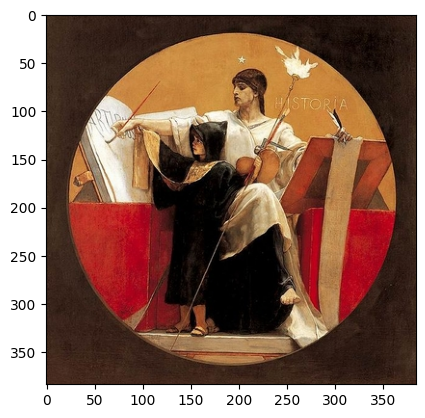

In [ ]:
# Load image example
image = Image.open("/data/vifapi/ameed_ahmed_thesis/HildesheimThesis/CSWin_Transformer_main/dataset_resized/train_val_combi/train_academicism_preprocessed_384_dataset/ηistoria.jpg")
plt.imshow(image)
print(image.size)
print(np.array(image).shape)

In [ ]:
# Class Prediction example - FIXED VERSION
with torch.no_grad():
    model = model.to(device)
    
    # Check if image is already a tensor
    if isinstance(image, torch.Tensor):
        # If it's already a tensor, just apply normalization and ensure correct shape
        if image.dim() == 3:
            image = image.unsqueeze(0)  # Add batch dimension if needed
        # Apply normalization if not already normalized
        if image.max() > 1.0:  # Assuming image is in [0, 255] range
            image = image / 255.0
        # Apply ImageNet normalization
    else:
        # If it's a PIL Image, apply the full transform pipeline
        transform = T.Compose([
            T.Resize(384),
            T.CenterCrop(384),
            T.ToTensor(),  # This was missing!,
        ])
        image = transform(image).unsqueeze(0)
    
    image = image.to(device)
    model = model.to(device)
    # Remove the extra unsqueeze here - image already has batch dimension
    output = classifier(image)  # Don't call unsqueeze again!
    print(output.shape)
    predicted_class = np.argmax(output.cpu().detach().numpy())
    print(predicted_class)
    labels = {y:x for x,y in labels.items()}
    print('Class: ' + labels[predicted_class])

torch.Size([1, 6])
1
Class: academicism


Number of superpixels: 107


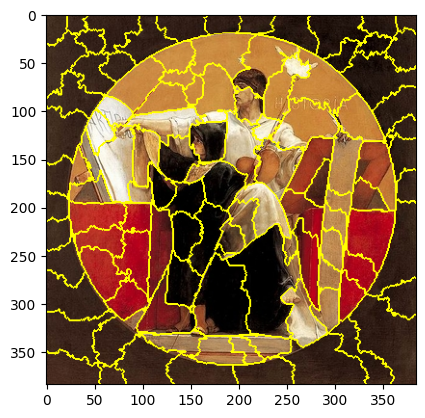

In [ ]:
# Create segments
image = (image.cpu())
image_tensor = image[0].clone().detach().permute(1, 2, 0)
image = image[0].permute(1, 2, 0).numpy()
segments = quickshift(image, kernel_size=4, max_dist=200, ratio=0.2)

plt.imshow(mark_boundaries(image, segments))
print("Number of superpixels: " + str(len(np.unique(segments))))

In [ ]:
image_tensor.clone().detach().cpu().numpy().shape

(384, 384, 3)

In [ ]:
%%time
# CREATE RANDOM CFs - CHANGE UNTIL THE FACTUAL CLASS IS FLIPPED
from isedc.sedc import sedc # SEDC makes that
# Create segments
segments = quickshift(image, kernel_size=4, max_dist=200, ratio=0.2)

# Try to generate CF
image_tensor = torch.tensor(image).permute(2, 0, 1).float()
image_tensor = image_tensor.unsqueeze(0)
explanation, segments_in_explanation, perturbation, new_class = sedc(image_tensor, classifier, segments, 'inpaint', device)

# Show explanation image 
plt.imshow(explanation)
print(imagenet_labels[new_class])

torch.Size([1, 3, 384, 384])


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 384

In [ ]:
%%time
# CREATE TARGETED CF WITH ORIGINAL, NOT OPTIMIZED, FUNCTION
from isedc.sedc_t2 import sedc_t2

# Create segments
segments = quickshift(image, kernel_size=4, max_dist=200, ratio=0.2)

# Try to generate CF targeting "French bulldog"
explanation, segments_in_explanation, perturbation, new_class = sedc_t2(
    image, 
    classifier, 
    segments, 
    np.where(imagenet_labels=='French bulldog')[0][0], 
    'random')

# Show explanation image
plt.imshow(explanation)
print(imagenet_labels[new_class])

NameError: name 'imagenet_labels' is not defined

In [ ]:
%%time
# CREATE TARGETED CF WITH OPTIMIZED FUNCTION
from isedc.sedc_t2_fast import sedc_t2_fast

# Create segments
segments = quickshift(image, kernel_size=4, max_dist=200, ratio=0.2)

# Try to generate CF targeting "French bulldog" UNDER 600 SECONDS
explanation, segments_in_explanation, perturbation, new_class = sedc_t2_fast(
    image, 
    classifier, 
    segments, 
    np.where(imagenet_labels=='French bulldog')[0][0], 
    'random', 
    max_time=600)

# Show explanation image
plt.imshow(explanation)
print(imagenet_labels[new_class])

NameError: name 'imagenet_labels' is not defined